In [1]:
import numpy as np
import pandas as pd

In [2]:
path = ("C:/Users/Ong Jia Yi/Desktop/STUDY/Summer 2021"
        "/Rotman MMA Summer 2021 Datathon")

# hereafter called 'the original dataframe'
load = pd.read_csv(path + "/NWHL.csv")

### DEFINITIONS
1) "outcomes" is defined to be the end of a sequence of prior events that are of interest.

## Function - prior_events

In [3]:
def prior_events(outcome_data):
    """Return a dataframe of the details of events that led to an outcome
    of interest.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.Indexes of <outcome_data>
                    preserves that of the original dataframe.
    Returns:
    new_frame -- Pandas DataFrame containing info. on prior events.
    """
    new_frame = []
    for i in outcome_data.index:

        new_row = []
        for j in range(1, window_len+1):
            last_event = load.loc[i-j, outcome_data.columns]
            last_event = np.array(last_event)
            new_row.append(last_event)
        new_row = np.concatenate(new_row)

        new_frame.append([new_row])
    
    new_frame = pd.DataFrame(np.concatenate(new_frame))
    colnames = ["{}_l{}".format(name, i) for i in range(1, window_len+1) \
                for name in outcome_data.columns]
    new_frame.columns = colnames
    
    return new_frame

## Function - encode_player

In [4]:
def encode_players(outcome_data, prior_events_data, all_players, window_len):
    """Encode the outcome player and prior event player(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    all_players -- a Numpy array of all player names in the original 
                   dataset (no repetition).
    window_len -- (int) the number of previous events to include.
    
    Returns:
    player_encoded -- a Pandas DataFrame of the IDs of the player associated
                      to the outcome and prior events.
    """
    outcome_player = outcome_data.Player.reset_index(drop=True)
    prior_players = prior_events_data.filter(regex="Player").reset_index(drop=True)

    merged = pd.concat([outcome_player, prior_players], ignore_index=True, axis=1)
    
    # plus one so ID starts at 1
    players_encoded = merged.applymap(lambda x: np.where(x == all_players)[0][0] + 1)
    
    return players_encoded

## Function - one_hot_encoder

In [5]:
def one_hot_encoder(categories):
    """Creates a one-hot encoding for categorical data
    e.g. name of event or name of player.
    
    Arguments:
    categories -- Numpy array of all instances of the categorical data.
    
    Returns:
    oh_dict -- dictionary that maps instance of categorical data to 
               a Numpy array of one-hot encoding integers.
    """
    oh_mat = pd.get_dummies(categories)
    
    oh_dict = dict()
    for cat in categories:
        oh_dict[cat] = np.array(oh_mat.loc[:, cat])
        
    return oh_dict

## Function - encode_events

In [6]:
def encode_events(outcome_data, prior_events_data, event_oh, window_len):
    """Encode the outcome and prior event(s) by their IDs,
    which are their order of appearance in the original dataset.
    
    Arguments:
    outcome_data -- subset of the original Pandas DataFrame where
                    the outcome(s) of interest occur.
    prior_events_data -- output from prior_events() function with 
                         the same <outcome_data> input.
    event_oh -- one-hot-encoding dictionary for events.
    window_len -- (int) the number of previous events to include.
    
    Returns:
    events_encoded -- a Pandas DataFrame of the IDs of the event associated
                      to the outcome and prior events.
    """
    outcome_events = outcome_data.Event.reset_index(drop=True)
    outcome_events = pd.DataFrame(outcome_events).applymap(lambda x: event_oh[x])
    
    prior_events = prior_events_data.filter(regex="Event").reset_index(drop=True)
    prior_events = pd.DataFrame(prior_events).applymap(lambda x: event_oh[x])
    
    target_events_encoded = pd.DataFrame(outcome_events.iloc[:,0].to_list())
    events_encoded = pd.DataFrame(prior_events.iloc[:,0].to_list())
    
    for i in range(1, prior_events.shape[1]):
        prior_encoded_sub = pd.DataFrame(prior_events.iloc[:,i].to_list())
        events_encoded = pd.concat([events_encoded, prior_encoded_sub], axis=1)
    
    
    return target_events_encoded, events_encoded

## Implementing functions

In [7]:
# interested in events leading to outcomes of Shot/Goal
outcomes_interest = ["Shot", "Goal"]

# capture two prior events leading to outcome
window_len = 2

#  a list of variable names to describe prior events.
detail_names = ['Period', 'Home Team Skaters', 'Away Team Skaters',
                'X Coordinate', 'Y Coordinate', 'Player', 'Event']

# Subset rows only with Event == Shot/Goal
# Indexes of <outcome_data> preserves that of the original dataframe.
outcome_data = load.loc[load.Event.isin(outcomes_interest), detail_names]

In [8]:
prior_events_data = prior_events(outcome_data)
prior_events_data.head()

,Period_l1,Home Team Skaters_l1,Away Team Skaters_l1,X Coordinate_l1,Y Coordinate_l1,Player_l1,Event_l1,Period_l2,Home Team Skaters_l2,Away Team Skaters_l2,X Coordinate_l2,Y Coordinate_l2,Player_l2,Event_l2
0,1,5,5,125,28,McKenna Brand,Zone Entry,1,5,5,107,40,McKenna Brand,Puck Recovery
1,1,5,5,124,2,Allie Thunstrom,Zone Entry,1,5,5,112,0,Allie Thunstrom,Takeaway
2,1,5,5,168,10,Allie Thunstrom,Play,1,5,5,124,20,Nina Rodgers,Zone Entry
3,1,5,5,135,52,Jillian Dempsey,Play,1,5,5,125,70,Jillian Dempsey,Zone Entry
4,1,5,5,196,20,Lauren Kelly,Puck Recovery,1,5,5,174,82,Jillian Dempsey,Incomplete Play


In [9]:
encoded_players = encode_players(outcome_data, prior_events_data, load.Player.unique(), window_len)
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


In [10]:
event_oh = one_hot_encoder(load.Event.unique())
event_oh["Shot"]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [11]:
load.Event.unique()

array(['Faceoff Win', 'Puck Recovery', 'Zone Entry', 'Shot', 'Play',
       'Takeaway', 'Dump In/Out', 'Incomplete Play', 'Penalty Taken',
       'Goal'], dtype=object)

In [12]:
target_encoded_events, encoded_events = encode_events(outcome_data, prior_events_data, event_oh, window_len)
encoded_events.head()

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


## Finalize data

### Event data

In [13]:
final_event_data_1 = outcome_data.drop(["Player", "Event"], axis=1)
final_event_data_1 = final_event_data_1.reset_index(drop=True)
final_event_data_1.head()

,Period,Home Team Skaters,Away Team Skaters,X Coordinate,Y Coordinate
0,1,5,5,131,28
1,1,5,5,162,2
2,1,5,5,167,18
3,1,5,5,175,68
4,1,5,5,196,20


In [14]:
final_event_data_2 = prior_events_data.drop(list(prior_events_data.filter(regex="Event|Player")), axis=1)
final_event_data_2 = final_event_data_2.reset_index(drop=True)
final_event_data_2.head()

,Period_l1,Home Team Skaters_l1,Away Team Skaters_l1,X Coordinate_l1,Y Coordinate_l1,Period_l2,Home Team Skaters_l2,Away Team Skaters_l2,X Coordinate_l2,Y Coordinate_l2
0,1,5,5,125,28,1,5,5,107,40
1,1,5,5,124,2,1,5,5,112,0
2,1,5,5,168,10,1,5,5,124,20
3,1,5,5,135,52,1,5,5,125,70
4,1,5,5,196,20,1,5,5,174,82


In [15]:
final_event_data = pd.concat([encoded_events, final_event_data_1, final_event_data_2], ignore_index=True, axis=1)
final_event_data.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0,0,1,0,0,0,0,0,0,0,...,1,5,5,125,28,1,5,5,107,40
1,0,0,1,0,0,0,0,0,0,0,...,1,5,5,124,2,1,5,5,112,0
2,0,0,0,0,1,0,0,0,0,0,...,1,5,5,168,10,1,5,5,124,20
3,0,0,0,0,1,0,0,0,0,0,...,1,5,5,135,52,1,5,5,125,70
4,0,1,0,0,0,0,0,0,0,0,...,1,5,5,196,20,1,5,5,174,82


### Player data

In [16]:
encoded_players.head()

,0,1,2
0,2,2,2
1,11,11,11
2,13,11,13
3,2,1,1
4,19,19,1


## Train-test split

In [17]:
import random

In [18]:
nrow = encoded_players.shape[0]
random_ind = [i for i in range(0, nrow)]
random.shuffle(random_ind)

In [32]:
train_test_split = 0.9
split = int(train_test_split*nrow)

In [74]:
X_train_player = encoded_players.loc[random_ind[:split]]
X_train_event = final_event_data.loc[random_ind[:split]]
y_train = target_encoded_events.iloc[random_ind[:split], -1:] # last column is Goal
y_train = np.array(y_train).reshape(y_train.shape[0], 1)

X_test_player = encoded_players.loc[random_ind[split:]]
X_test_event = final_event_data.loc[random_ind[split:]]
y_test = target_encoded_events.iloc[random_ind[split:], -1:] # last column is Goal
y_test = np.array(y_test).reshape(y_test.shape[0], 1)

In [72]:
X_train_player.shape

(1786, 3)

In [75]:
y_train.shape

(1786, 1)

## Mixed Data Neural Network

In [90]:
from kerastuner import HyperModel

import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import (Embedding, InputLayer, Dense,
                                     Flatten, Activation)
from tensorflow.keras import optimizers
from tensorflow.keras import metrics

In [144]:
class Hypermodel(HyperModel):
    def __init__(self, input_shape, n_players, emb_dim):
        self.input_shape = input_shape
        self.n_players = n_players
        self.emb_dim = emb_dim
        
    def build(self, hp):
        model = keras.Sequential()
        model.add(InputLayer(input_shape=self.input_shape))
        model.add(Embedding(self.n_players, self.emb_dim, trainable=True))
        
        model.add(
            Dense(units=hp.Int('units_1', 
                               min_value=16, 
                               max_value=128, 
                               step=16),
                  activation=hp.Choice('activation_1', 
                                       values=['relu', 'tanh', 'sigmoid']))
        )
        model.add(
            Dense(units=hp.Int('units_2', 
                               min_value=16, 
                               max_value=128, 
                               step=16),
                  activation=hp.Choice('activation_2', 
                                       values=['relu', 'tanh', 'sigmoid']))
        )
        model.add(Flatten(data_format=None))
        model.add(Dense(units=1))
        model.add(Activation(activation='sigmoid'))
        
        model.compile(
            optimizer=optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-4, 
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss='binary_crossentropy',
            metrics=[metrics.BinaryAccuracy(), metrics.AUC()]
        )
        
        return model

In [145]:
input_shape = (X_train_player.shape[1],)
n_players = len(load.Player.unique())
emb_dim = 20

hypermodel = Hypermodel(input_shape, n_players, emb_dim)

## Hyperparameter Tuning

In [125]:
import kerastuner
from kerastuner.tuners import RandomSearch
from keras.callbacks import EarlyStopping

In [146]:
tuner = RandomSearch(
    hypermodel,
    objective=kerastuner.Objective("auc", direction="max"),
    seed=1,
    max_trials=10,
    executions_per_trial=2,
    directory='random_search',
    overwrite=True
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)

In [130]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [147]:
N_EPOCH_SEARCH = 10
tuner.search(X_train_player, y_train, epochs=N_EPOCH_SEARCH, 
             validation_split=0.2, callbacks=[stop_early])

Trial 10 Complete [00h 00m 04s]
auc: 0.8561235070228577

Best auc So Far: 0.9141269624233246
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit


In [148]:
tuner.results_summary(1)

Results summary
Results in random_search\untitled_project
Showing 1 best trials
Objective(name='auc', direction='max')
Trial summary
Hyperparameters:
units_1: 64
activation_1: tanh
units_2: 48
activation_2: relu
learning_rate: 0.008520876742029873
Score: 0.9141269624233246


## Final Model

In [149]:
best_hyppar = tuner.get_best_hyperparameters(num_trials=1)[0]
final_model = tuner.hypermodel.build(best_hyppar)
final_model.fit(X_train_player, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
45/45 [==============================] - 1s 9ms/step - loss: 0.2326 - binary_accuracy: 0.9524 - auc: 0.4748 - val_loss: 0.1556 - val_binary_accuracy: 0.9637 - val_auc: 0.5734
Epoch 2/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1520 - binary_accuracy: 0.9629 - auc: 0.7151 - val_loss: 0.1743 - val_binary_accuracy: 0.9637 - val_auc: 0.5482
Epoch 3/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1351 - binary_accuracy: 0.9629 - auc: 0.8287 - val_loss: 0.1984 - val_binary_accuracy: 0.9637 - val_auc: 0.5382
Epoch 4/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1218 - binary_accuracy: 0.9601 - auc: 0.8831 - val_loss: 0.2245 - val_binary_accuracy: 0.9637 - val_auc: 0.4824
Epoch 5/10
45/45 [==============================] - 0s 2ms/step - loss: 0.1136 - binary_accuracy: 0.9622 - auc: 0.9001 - val_loss: 0.2545 - val_binary_accuracy: 0.9525 - val_auc: 0.5320
Epoch 6/10
45/45 [==============================] - 0s 2ms/step - loss

In [150]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 20)             2520      
_________________________________________________________________
dense (Dense)                (None, 3, 64)             1344      
_________________________________________________________________
dense_1 (Dense)              (None, 3, 48)             3120      
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 145       
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 7,129
Trainable params: 7,129
Non-trainable params: 0
______________________________________________________

In [153]:
loss, accuracy, auc = final_model.evaluate(X_test_player, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.3332 - binary_accuracy: 0.9397 - auc: 0.5566


In [139]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [157]:
pred = final_model.predict(X_test_player)
pred = (pred >= 0.5).astype('uint8')

In [160]:
cm = confusion_matrix(y_test, pred)
cm

array([[186,   3],
       [  9,   1]], dtype=int64)

In [159]:
roc_auc_score(y_test, pred)

0.5420634920634921

## Player Embeddings

In [167]:
embs = final_model.layers[0].get_weights()[0]

In [168]:
embs.shape

(126, 20)

In [175]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

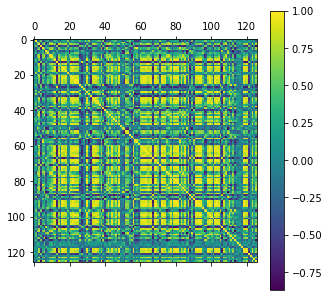

In [248]:
cos_sim = cosine_similarity(embs)
plt.matshow(cos_sim)
plt.colorbar()
plt.show()

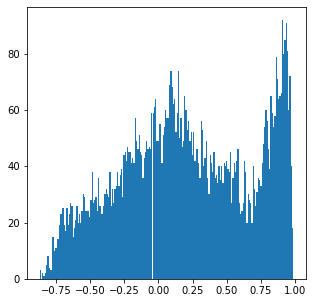

In [298]:
upp_tri = np.triu_indices(cos_sim.shape[0], 1)
plt.hist(cos_sim[upp_tri], bins=200)
plt.show()